In [1]:
import csv
import typing as tp
import pickle
from collections import defaultdict
import random

import numpy as np
import keras
import re
import keras.layers
import keras.optimizers
import keras.callbacks
import eng_to_ipa
from unidecode import unidecode
from tqdm import tqdm
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from Levenshtein import distance as lev


In [2]:
MODEL_NAME = 'RhymeModelPOL'
POL = True if MODEL_NAME.endswith('POL') else False

TO_EXCLUDE = '!"#$%&()*+-—/:;<=>@[\\]^_`{|}~.,:;!?\t«»'
TO_TOKENIZE = '\n'

In [3]:
def load_data(file, include: str, exclude: str, size: int = None):
    _text =  []
    with open(file, encoding='UTF-8') as f:
        data = csv.reader(f)
        for verse, *_ in tqdm(list(data)[:size] if size is not None else list(data)):
            # Separate characters that we want to tokenize
            correct_verse = re.sub(r'(['+include+'])', r' \1 ', verse)
            # Exclude characters that we do not want to tokenize
            correct_verse = correct_verse.translate(str.maketrans('', '', exclude))
            _text.append(correct_verse.lower())
    return _text

if POL:
    TEXT = load_data('data/poems/pl/treny.csv', TO_TOKENIZE, TO_EXCLUDE)
    TEXT += load_data('data/poems/pl/slowacki.csv', TO_TOKENIZE, TO_EXCLUDE)
else:
    TEXT = load_data('data/poems/eng/limericks.csv', TO_TOKENIZE, TO_EXCLUDE, 20000)
print(*TEXT[:3])

100%|██████████| 713/713 [00:00<00:00, 21605.60it/s]

wszytki płacze wszytki łzy heraklitowe 
 i lamenty i skargi symonidowe 
 wszytki troski na świecie wszytki wzdychania 
 i żale i frasunki i rąk łamania 
  wszytki a wszytki za raz w dom się mój noście 
 a mnie płakać mej wdzięcznej dziewki pomożcie 
 z którą mię niepobożna śmierć rozdzieliła 
 i wszytkich moich pociech nagle zbawiła 
  tak więc smok upatrzywszy gniazdko kryjome 
 słowiczki liche zbiera a swe łakome 
 gardło pasie tymczasem matka szczebiece 
 uboga a na zbójcę coraz się miece 
 


In [4]:
def extract_rhymes(_text: tp.List[str], rhyme_scheme: str = None):
    rhymes = defaultdict(list)

    def find_rhyme_schema(words: tp.List[str]):
        schema = ''.join([word[-1] for word in words])
        schema = unidecode(schema)
        return schema

    def add_rhymes(rhyme_words: tp.List[str]):
        for word in rhyme_words:
            others = rhyme_words.copy()
            others.remove(word)
            rhymes[word].extend(others)

    for verse_number, verse in tqdm(enumerate(_text)):
        rhymes_by_letter = defaultdict(list)
        lines = [l for l in verse.strip().split('\n') if l.strip()]
        try:
            last_words = [line.strip().split(' ')[-1] for line in lines]
            used_rhyme_scheme = rhyme_scheme or find_rhyme_schema(last_words)
            if len(last_words) != len(used_rhyme_scheme):
                raise IndexError
            [rhymes_by_letter[letter].append(word) for letter, word in zip(used_rhyme_scheme, last_words)]
            [add_rhymes(rhyme) for rhyme in rhymes_by_letter.values()]
        except IndexError as e:
            print(f"Invalid verse with number {verse_number} {e}")
            continue
    return {k: list(set(v)) for k, v in rhymes.items()}

RHYMES = extract_rhymes(TEXT, None if POL else "AABBA") # For english limericks use "AABBA" schema
print(f"Size of vocabulary: {len(RHYMES)}")
MINIMUM_OCCURRENCES = 1 if POL else 6
RHYMES = {k:v for k, v in RHYMES.items() if len(v) >= MINIMUM_OCCURRENCES}
print(f"Size of reduced vocabulary: {len(RHYMES)}")

print("...")
print(*[f"{k}: {v}\n" for k, v in sorted(RHYMES.items())[100:110]])
print("...")
most_common = max(RHYMES.keys(), key=lambda x: len(RHYMES[x]))
print(f"Most common rhyme: '{most_common}' | Length: {len(RHYMES[most_common])} | Rhymes: {RHYMES[most_common][:10]} ...")

859it [00:00, 3491.87it/s]

Size of vocabulary: 2367
Size of reduced vocabulary: 2008
...
błyskawica: ['pokolenia', 'wystarcza', 'dziedzica', 'kuźnica', 'księżyca', 'szatana', 'tarcza', 'świszczą', 'imienia', 'kolana']
 błyskawice: ['nieruchome', 'świadome', 'cienie', 'zrennice', 'płomienie', 'wypalę']
 błyskawicą: ['pochwycą']
 błyskał: ['ściskał', 'służył', 'przedłużył']
 błyski: ['fali', 'żali', 'bliski']
 błysku: ['ucisku']
 błyśnie: ['umyślnie']
 błękicie: ['głowę', 'życie']
 błękitami: ['sami', 'nami']
 błękitem: ['świtem']

...
Most common rhyme: 'boże' | Length: 20 | Rhymes: ['morze', 'ugorze', 'położę', 'może', 'ogromnie', 'podnoże', 'przemoże', 'osuszę', 'otworzę', 'łoże'] ...


In [5]:
TOKENIZER = Tokenizer(filters=TO_EXCLUDE, char_level=True)
WORDS = ' '.join(list(RHYMES.keys()) + [w for rhymes in RHYMES.values() for w in rhymes])
TOKENIZER.fit_on_texts(WORDS)
TOTAL_CHARS = len(TOKENIZER.word_index) + 1
print(TOTAL_CHARS)
print(TOKENIZER.word_index)

35
{' ': 1, 'a': 2, 'i': 3, 'e': 4, 'o': 5, 'z': 6, 'n': 7, 'r': 8, 'y': 9, 'c': 10, 's': 11, 'w': 12, 'm': 13, 'ł': 14, 'k': 15, 't': 16, 'd': 17, 'p': 18, 'u': 19, 'l': 20, 'b': 21, 'ę': 22, 'g': 23, 'j': 24, 'ą': 25, 'h': 26, 'ż': 27, 'ś': 28, 'ó': 29, 'ć': 30, 'ń': 31, 'f': 32, 'ź': 33, 'é': 34}


In [6]:
def create_sequences(rhymes: tp.Dict[str, tp.List[str]], tokenizer: Tokenizer):
    sequences = []
    for base_word, rhymes_words in tqdm(rhymes.items()):
        for rhyme_word in rhymes_words:
            seq = f"{base_word} {rhyme_word} "
            encoded = tokenizer.texts_to_sequences(seq)
            if [] in encoded:
                print()
            for i in range(len(base_word) + 2, len(encoded) + 1):
                sequences.append(encoded[:i])
    return sequences

SEQUENCES = create_sequences(RHYMES, TOKENIZER)
print(f"Size of training set {len(SEQUENCES)}")

100%|██████████| 2008/2008 [00:00<00:00, 11811.93it/s]

Size of training set 26153


In [7]:
SEQUENCE_LENGTH = max([len(seq) for seq in SEQUENCES])
ENCODED_SEQUENCES = pad_sequences(SEQUENCES, maxlen=SEQUENCE_LENGTH, padding='pre')
X, y = ENCODED_SEQUENCES[:,:-1], to_categorical(ENCODED_SEQUENCES[:,-1], num_classes=TOTAL_CHARS)
print(f'Max Sequence Length: {SEQUENCE_LENGTH}')

Max Sequence Length: 29


In [8]:
def create_model(total_chars: int, sequence_length: int):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(total_chars, 128, input_length=sequence_length - 1))
    model.add(keras.layers.LSTM(128, return_sequences=True, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(128, return_sequences=True, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(128, return_sequences=True, activation='tanh'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(64, return_sequences=True, activation='tanh'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(64, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(total_chars, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

MODEL_PATH = f"data/models/{MODEL_NAME}/weights.h5"
MODEL = keras.models.load_model(MODEL_PATH)
# MODEL = create_model(TOTAL_CHARS, SEQUENCE_LENGTH)
print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 128)           4480      
                                                                 
 lstm (LSTM)                 (None, 28, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 28, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 28, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 28, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 28, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 28, 128)           0

In [9]:
REVERSE_TOKEN_INDEX = {v: k for k, v in TOKENIZER.word_index.items()}

def generate_rhyme(model: keras.Model, in_word: str):
    in_word = in_word + " " if in_word[-1] != " " else in_word
    for i in range(20):
        encoded = TOKENIZER.texts_to_sequences([in_word])[0]
        padded = pad_sequences([encoded], maxlen=model.input_shape[-1], padding='pre')
        predicted = np.argmax(model.predict(padded, verbose=0))
        out_char = REVERSE_TOKEN_INDEX.get(predicted, None)
        if out_char == " " or out_char is None:
            break
        in_word += out_char
    return in_word

In [65]:
def create_callbacks():
    callbacks = []

    class PredictionCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            frequency = 1
            if epoch % frequency:
                return
            rhyme_dict = list(RHYMES.keys())
            print()
            print(generate_rhyme(MODEL, rhyme_dict[10]))
            print(generate_rhyme(MODEL, rhyme_dict[30]))
            print(generate_rhyme(MODEL, rhyme_dict[50]))
            print(generate_rhyme(MODEL, rhyme_dict[70]))

    callbacks.append(PredictionCallback())
    callbacks.append(keras.callbacks.EarlyStopping(monitor="loss", patience=3))
    callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=f"data/models/{MODEL_NAME}/checkpoint",
        save_weights_only=True,
        monitor='loss',
        save_best_only=True
    ))
    return callbacks


In [66]:
HISTORY = MODEL.fit(
    X,
    y,
    epochs=100,
    verbose=1,
    batch_size=128,
    shuffle=True,
    callbacks=create_callbacks()
)

MODEL.save(MODEL_PATH)

Epoch 1/100
  8/205 [>.............................] - ETA: 2:07 - loss: 0.7459 - accuracy: 0.7637

KeyboardInterrupt: 

In [ ]:
with open(f"data/models/{MODEL_NAME}/tokenizer.pickle", 'wb') as f:
    pickle.dump(TOKENIZER, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"data/models/{MODEL_NAME}/history.pickle", 'wb') as f:
    pickle.dump(HISTORY.history, f, protocol=pickle.HIGHEST_PROTOCOL)

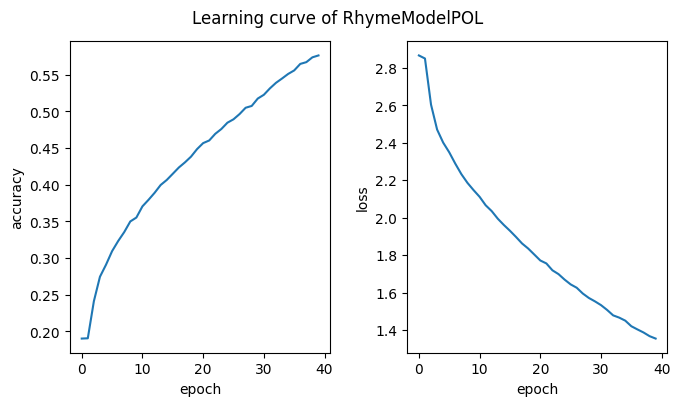

In [24]:
with open(f"data/models/{MODEL_NAME}/history.pickle", "rb") as f:
    history = pickle.load(f)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f"Learning curve of {MODEL_NAME}")

ax1.plot(history['accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')

ax2.plot(history['loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
fig.tight_layout()
fig.set_size_inches(7, 4)
fig.savefig(f"data/models/{MODEL_NAME}/learning_curve.png")
plt.show()

In [61]:
for _ in range(10):
    print(generate_rhyme(MODEL, random.choice(list(RHYMES.keys()))))

zaświeca przeszęka
łezka czoła
ciężarna czarna
dziki bręki
postawę postawę
salaminy niepierzy
pień dzień
łamania szatana
błyskawicą przychylą
głowica świta


In [63]:
def measure_rhyming(model: keras.Model, rhymes: dict, tests: int = 50, ipa: bool = False):
    result = []
    for _ in tqdm(range(tests)):
        word = random.choice(list(rhymes.keys()))
        rhyme = generate_rhyme(model, word).split(' ')[-1]
        for index_distance in range(1, 4):
            if ipa:
                a = eng_to_ipa.convert(word)[-index_distance:]
                b = eng_to_ipa.convert(rhyme)[-index_distance:]
            if not ipa or b.endswith('*'):
                a = word[-index_distance:]
                b = rhyme[-index_distance:]
            result.append(1 - lev(a, b) / max(len(a), len(b)))
    return np.mean(result)

rhyming_score = measure_rhyming(MODEL, RHYMES, ipa=not POL)
print(f"Rhyming score: {rhyming_score}")

100%|██████████| 50/50 [00:45<00:00,  1.10it/s]

Rhyming score: 0.7255555555555556
